In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pylab import rcParams
import re
import time
from datetime import datetime
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("readings.csv", on_bad_lines='error')
display(df.shape, df.sample(10))

(2500, 5)

,cpu_speed,volts,cpu_pct,load_avg,temp
337,2.400024,0.8925,100.0,5.815430,57.6
1945,1.600020,0.7825,1.9,1.109375,45.5
939,2.400020,0.8925,100.0,6.801270,62.6
1508,2.400030,0.8925,100.0,5.956543,60.9
1673,1.500016,0.7500,2.8,3.431152,48.8
1965,2.400027,0.8925,52.7,1.181152,49.4
1723,1.500023,0.7500,0.0,2.903320,48.8
332,2.400024,0.8925,100.0,4.841309,59.8
606,2.400024,0.8925,100.0,6.769043,61.5
1194,2.400034,0.8925,100.0,6.689941,62.0


<Figure size 640x480 with 0 Axes>

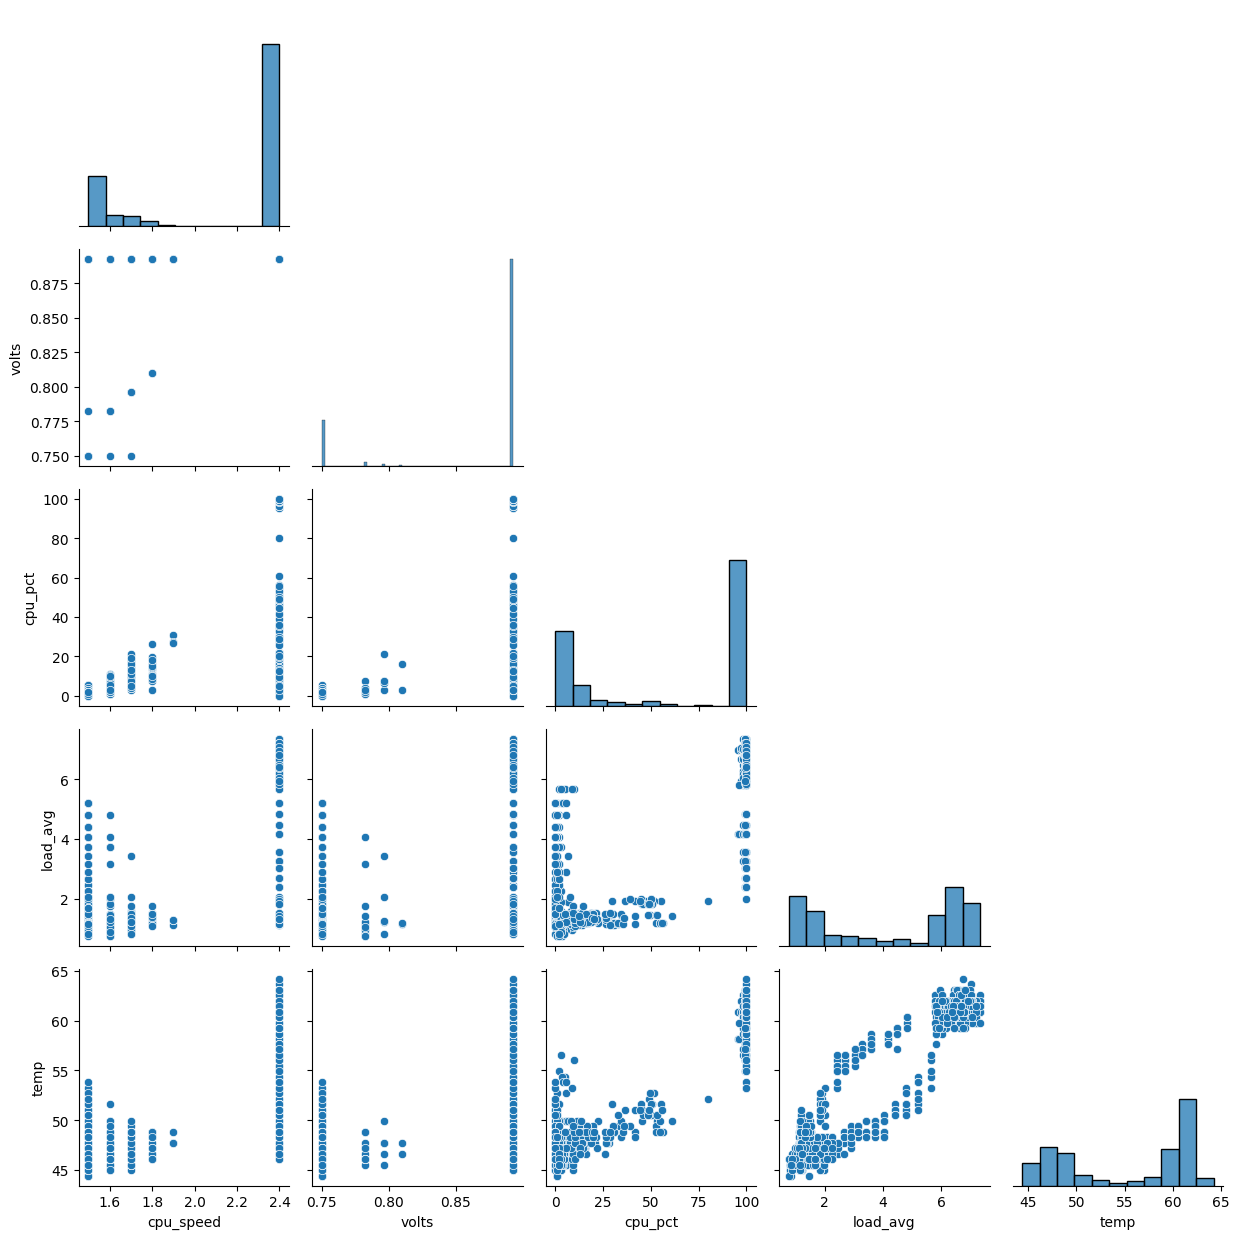

In [3]:
plt.clf()
# scatter_matrix(df.sample(2000), figsize=(10, 8))
sns.pairplot(df.sample(1000), kind="scatter", diag_kind="hist", corner=True)
plt.tight_layout() 
plt.show()

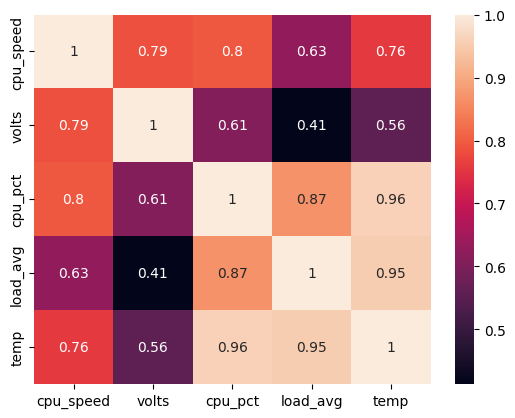

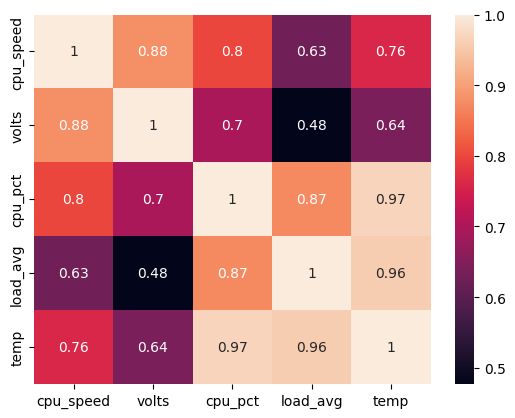

In [5]:
# 5-point rolling average to smooth noise
df_adjusted = df.copy()
rolling_cols = ["volts", "load_avg", "temp", "cpu_pct"]
df_adjusted[rolling_cols] = df_adjusted[rolling_cols].rolling(window=5).mean()

sns.heatmap(df.corr(), annot=True)
plt.show()
sns.heatmap(df_adjusted.corr(), annot=True)
plt.show()

# Basic Linear Regression
Predicting CPU temperature from metrics using linear models.

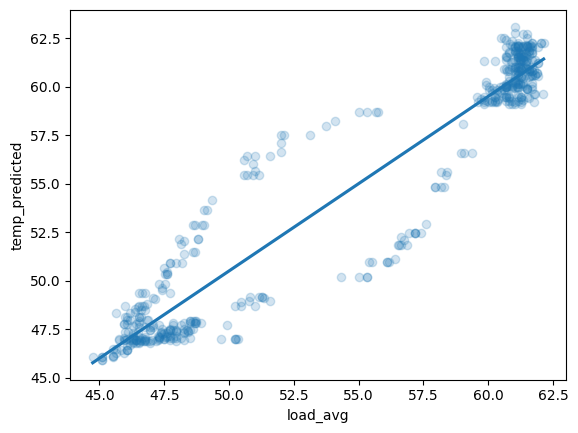

'Model coefficients: [6.29048901]'

'Model intercept: 54.90841683366733'

'Mean squared error: 3.78'

'Coefficient of determination: 0.91'

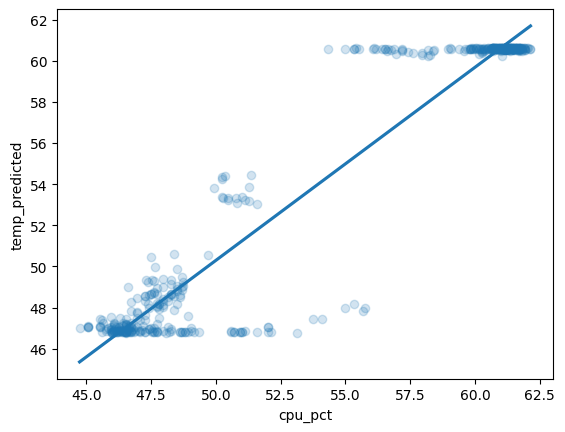

'Model coefficients: [6.34651094]'

'Model intercept: 54.90841683366733'

'Mean squared error: 3.10'

'Coefficient of determination: 0.93'

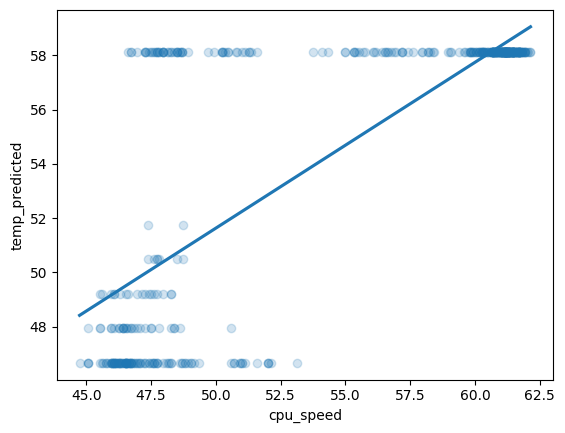

'Model coefficients: [4.92764307]'

'Model intercept: 54.90841683366734'

'Mean squared error: 15.99'

'Coefficient of determination: 0.63'

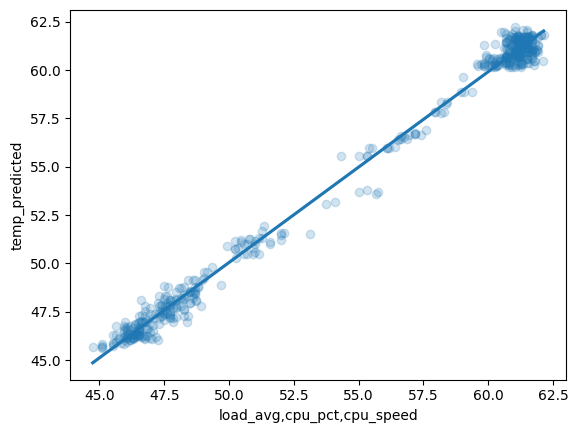

'Model coefficients: [3.26597394 3.17103469 0.39753608]'

'Model intercept: 54.90841683366733'

'Mean squared error: 0.31'

'Coefficient of determination: 0.99'

In [6]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Grab the adjusted data, but drop any rows with missing data.
# The rows with missing data were created by the rolling average.
df_data = df_adjusted.dropna(how="any")

# Try it first with each column, then with all. We know from the histograms
# that volts are not a good predictor.
linreg_feature_cols = ["load_avg", "cpu_pct", "cpu_speed"]
for fc in [[x] for x in linreg_feature_cols] + [linreg_feature_cols]:

    # Separate the feature data from the target data we want to predict.
    X = df_data[fc]
    y = df_data.temp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    plt.clf()

    linreg = make_pipeline(StandardScaler(), 
                           LinearRegression()) 
    linreg.fit(X_train,y_train)
    y_pred = linreg.predict(X_test)

    sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'alpha':0.2})
    plt.xlabel(",".join(fc))
    plt.ylabel('temp_predicted')
    plt.show()

    # Show some model stats
    regression_model = linreg.named_steps['linearregression']
    display(f"Model coefficients: {regression_model.coef_}")
    display(f"Model intercept: {regression_model.intercept_}")

    # We want a low mean squared error and a coefficient of determination (R^2) as close to 1 as possible.
    display(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
    display(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

# Basic Logistic Regression

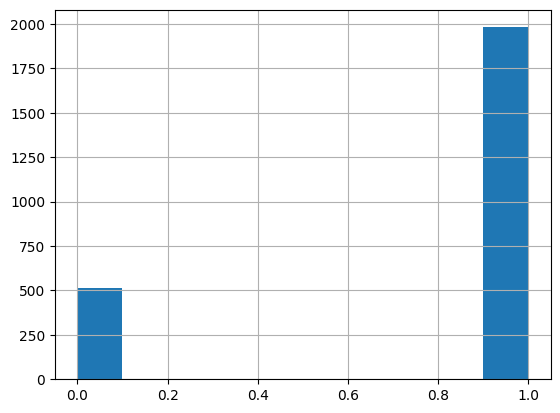

,cpu_speed,volts,cpu_pct,load_avg,temp,voltage_level
cpu_speed,1.000000,0.878685,0.799500,0.626548,0.760268,0.812951
volts,0.878685,1.000000,0.699577,0.476855,0.639615,0.949002
cpu_pct,0.799500,0.699577,1.000000,0.871985,0.967414,0.642586
load_avg,0.626548,0.476855,0.871985,1.000000,0.958930,0.429478
temp,0.760268,0.639615,0.967414,0.958930,1.000000,0.585022
voltage_level,0.812951,0.949002,0.642586,0.429478,0.585022,1.000000


'Train length: 1996, Test length: 500'

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       110
           1       0.99      0.94      0.96       390

    accuracy                           0.95       500
   macro avg       0.91      0.95      0.93       500
weighted avg       0.95      0.95      0.95       500



array([[106,   4],
       [ 23, 367]])

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df_data = df_adjusted.copy().dropna(how="any")

# Convert cpu voltage into a low/high indicator.
df_data["voltage_level"] = df_data.volts.apply(lambda x: 1 if x >= .825 else 0)
plt.clf()
df_data.voltage_level.hist()
plt.show()

display(df_data.corr())

logreg_feature_cols = ["temp", "cpu_speed", "cpu_pct"]

X = df_data[logreg_feature_cols].values
y = df_data.voltage_level.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

logreg = make_pipeline(StandardScaler(), 
                       LogisticRegression()) 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
display(metrics.confusion_matrix(y_test, y_pred))